In [2]:
import pathlib

import numpy as np
import pandas as pd
import sklearn.ensemble
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
def oriented_neighbors(x, direction, axis):
    xp = np.pad(x, 1)
    neighbors = (xp + np.roll(xp, direction, axis=axis))[1:-1, 1:-1] == 2
    index = np.roll(neighbors, -direction, axis=axis)
    return index.flatten(), neighbors.flatten()

In [5]:
def plane_to_adjacency(x):
    adj = np.zeros((x.size, x.size))
    for direction, axis in [(1, 0), (-1, 0), (1, 1), (-1, 1)]:
        index, neighbors = oriented_neighbors(x, direction, axis)
        adj[index, neighbors] = 1
    return adj

In [6]:
def only_connected(x):
    adjacency_matrix = plane_to_adjacency(x)
    graph = nx.from_numpy_matrix(adjacency_matrix)
    center = x.size // 2
    connected = list(next(component for component in nx.connected_components(graph) if center in component))
    features = np.zeros(x.size, dtype=x.dtype)
    features[connected] = 1
    return features.reshape(x.shape)

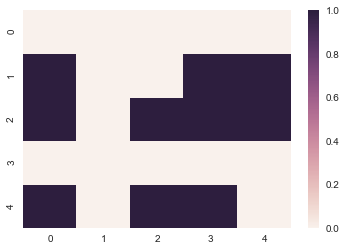

In [7]:
x = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1],
    [1, 0, 1, 1, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 1, 1, 0],
])
sns.heatmap(x)

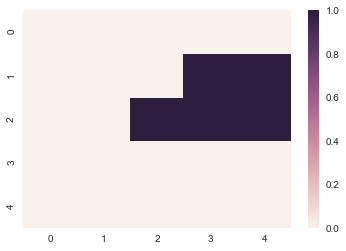

In [10]:
sns.heatmap(only_connected(x))

In [26]:
arrows = {"N": "↑", "E": "→", "S": "↓", "W": "←"}

def print_desks(desks):
    print("\n".join("".join(arrows.get(x, x) for x in line) for line in desks))

def dump_floor(desks, *, path):
    text = "\n".join("".join(arrows.get(x, x) for x in line) for line in desks_pred)
    pathlib.Path(path).write_text(text)

In [12]:
text = pathlib.Path("dataset-train.txt").read_text()
desks_train = np.array([list(line) for line in text.splitlines()])
desks_train = np.pad(desks_train, 2, constant_values=".")

In [17]:
rotations = {"N": "W", "E": "N", "S": "E", "W": "S"}
horizontal_flips = {"N": "N", "E": "W", "S": "S", "W": "E"}
vertical_flips = {"N": "S", "E": "E", "S": "N", "W": "W"}


def simple_features(j, i, presence):
    return (
        presence[j-1, i],
        presence[j-1, i] and presence[j-2, i],
        presence[j, i+1],
        presence[j, i+1] and presence[j, i+2],
        presence[j+1, i],
        presence[j+1, i] and presence[j+2, i],
        presence[j, i-1],
        presence[j, i-1] and presence[j, i-2],
    )


def advanced_features(j, i, presence):
    neighborhood = presence[j-2:j+3, i-2:i+3]
    neighborhood = only_connected(neighborhood)
    return tuple(neighborhood.flatten())


def augment_desks(desks):
    for n in range(4):
        rotated_desks = desks
        for i in range(n):
            rotated_desks = np.array([
                [rotations.get(value, value) for value in row] for row in np.rot90(rotated_desks)
            ])
            
        yield rotated_desks
        
        yield np.array([
            [vertical_flips.get(value, value) for value in row] for row in np.flip(rotated_desks, axis=0)
        ])
        
        
def floor_features(desks, get_features):
    def generate():
        desk_presence = (desks != ".").astype(int)
        seen = set()
        for (j, i), y_true in np.ndenumerate(desks):
            if y_true == ".":
                continue

            features = get_features(j, i, desk_presence)
            
            yield (j, i), features, y_true

    coords, X, y = zip(*generate())
    js, iss = zip(*coords)
    
    return (js, iss), X, y


def fit(desks, get_features):
    model = {}
    undecidable = set()

    for augmented_desks in augment_desks(desks):
        _, X, y = floor_features(augmented_desks, get_features)
        for x_train, y_true in zip(X, y):
            try:
                if model[x_train] != y_true:
                    undecidable.add(x_train)
                    del model[x_train]
            except KeyError:
                if x_train not in undecidable:
                    model[x_train] = y_true

    return model

In [18]:
simple_model = fit(desks_train, simple_features)
len(simple_model)

24

In [19]:
advanced_model = fit(desks_train, advanced_features)
len(advanced_model)

152

In [32]:
def fit_clf(desks):
    X, y = [], []
    for augmented_desks in augment_desks(desks):
        _, X_train, y_train = floor_features(augmented_desks, advanced_features)
        X += X_train
        y += y_train
        
    clf = sklearn.ensemble.RandomForestClassifier()
    clf.fit(X, y)
    
    return clf
    

ml_model = fit_clf(desks_train)

In [35]:
text = pathlib.Path("dataset-test.txt").read_text()
original_desks = np.array([list(line) for line in text.splitlines()])
original_desks = np.pad(original_desks, 2, constant_values=".")

rotated = [
    original_desks,
    np.rot90(original_desks),
    np.rot90(np.rot90(original_desks)),
    np.rot90(np.rot90(np.rot90(original_desks))),
]

verticals = [
    original_desks,
    rotated[2],
    np.flip(original_desks, axis=0),
    np.flip(rotated[2], axis=0),
]

horizontals = [
    rotated[1],
    np.flip(rotated[1], axis=0),
    rotated[3],
    np.flip(rotated[3], axis=0),
]

desks_test = np.concatenate(verticals, axis=1)
desks_test_2 = np.concatenate(horizontals, axis=0)

In [36]:
def predict_orientation(desks, model_name):
    desks_pred = np.array(desks)
    if model_name == "rf":
        coords, X, _ = floor_features(desks, advanced_features)
        y_pred = ml_model.predict(X)
        max_proba = ml_model.predict_proba(X).max(axis=1)
        y_pred[max_proba < 0.85] = "?"
    elif model_name == "simple":
        coords, X, _ = floor_features(desks, simple_features)
        y_pred = np.array([simple_model.get(x, "?") for x in X])
    elif model_name == "advanced":
        coords, X, _ = floor_features(desks, advanced_features)
        y_pred = np.array([advanced_model.get(x, "?") for x in X])
    elif model_name == "combined":
        coords, X_simple, _ = floor_features(desks, simple_features)
        _, X_advanced, _ = floor_features(desks, advanced_features)
        y_pred = np.array([
            simple_model.get(x_simple) or advanced_model.get(x_advanced) or "?"
            for x_simple, x_advanced in zip(X_simple, X_advanced)
        ])
    desks_pred[coords] = y_pred
    return desks_pred

    
for name in ["simple", "advanced", "combined", "rf"]:
    desks_pred = predict_orientation(desks_test, name)[2:-2, 2:-2]
    dump_floor(desks_pred, path=f"pred-{name}.txt")
    desks_pred = predict_orientation(desks_test_2, name)[2:-2, 2:-2]
    dump_floor(desks_pred, path=f"pred-{name}-horizontal.txt")

In [1]:
cd desk-orientation

/Users/axel/PycharmProjects/desk-orientation


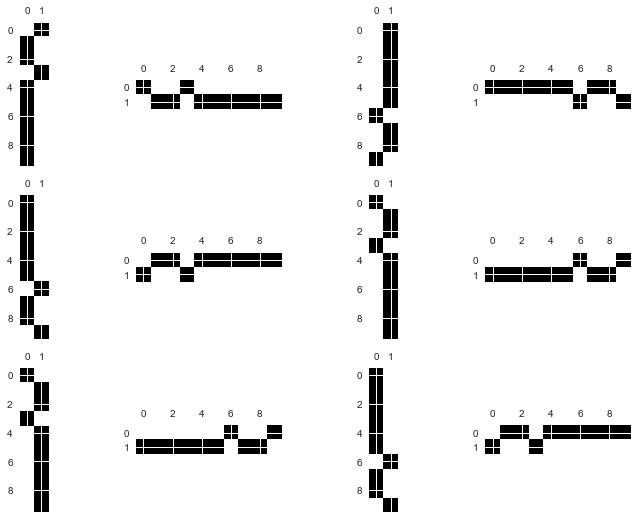

In [110]:
x = np.array([
    [0, 1],
    [1, 0],
    [1, 0],
    [0, 1],
    [1, 0],
    [1, 0],
    [1, 0],
    [1, 0],
    [1, 0],
    [1, 0],    
])

rotated = [
    x,
    np.rot90(x),
    np.rot90(np.rot90(x)),
    np.rot90(np.rot90(np.rot90(x))),
]

fig, axs = plt.subplots(3, 4, figsize=(12, 9))

for i in range(4):    
    axs[0][i].matshow(rotated[i])
    axs[1][i].matshow(np.flip(rotated[i], axis=0))
    axs[2][i].matshow(np.flip(rotated[i], axis=1))

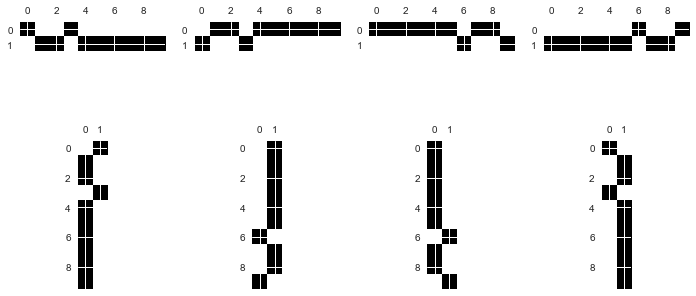

In [121]:
verticals = [
    x,
    rotated[2],
    np.flip(x, axis=0),
    np.flip(rotated[2], axis=0),
]

horizontals = [
    rotated[1],
    np.flip(rotated[1], axis=0),
    rotated[3],
    np.flip(rotated[3], axis=0),
]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    axs[0][i].matshow(horizontals[i])
    axs[1][i].matshow(verticals[i])

(10, 10)

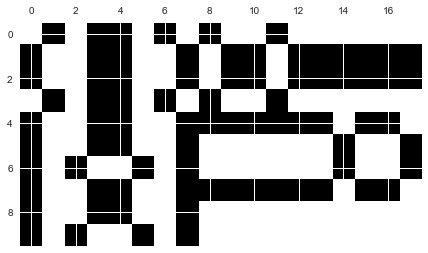

In [156]:
hs = np.concatenate(horizontals, axis=0)
vs = np.concatenate(verticals, axis=1)
pad_height = vs.shape[0] - hs.shape[0]
hs = np.pad(hs, ((0, pad_height), (0, 0)))
xs = np.concatenate((vs, hs), axis=1)
plt.matshow(xs)

In [125]:
vs.shape

(10, 8)

In [102]:
text = pathlib.Path("dataset-test.txt").read_text()

In [104]:
original_desks = np.array([list(line) for line in text.splitlines()])